# Assignment 2: Shengdi Lin

## 3 Practical Applications of Face Detection
1. Surveillance: Facial recognition can be used for scanning multiple faces for video surveillance. Casinos and retail chains have started incorporating this technology to identify when suspicious people enter their premises. By applying facial recognition to a real time video feed, one can identify individuals from cameras. This poses valid questions on when it acceptable to utilize such technology to keep the privacy of the public safe as well. 
2. Security: As noted before in Object detection, Facial detection is simply a more specialized version. iPhones are a great example that use this technology to find our face, recognize it, and determine whether it matches the profile it has saved to unlock the phone. By doing so, we move from passkeys and numeric passcodes to more biometric passcodes that tend to be safer and harder to impersonate or crack. 
3. Image Search: Objects in images can now be identified and labels can be created that allows users to utilize search functions in image libraries to look up generic terms. E.g., using an iPhone, one could look up a contact's name --- by creating a library of these faces, subsequent images with these contacts will have labels saved to them that identify which contacts in the photo are known and have been identified. 

In [56]:
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import numpy as np
import random

# Preprocess the Data

We are going to use "sportsteam.png" as provided as a sample of how we prepare the data as well as visualize the entire process.

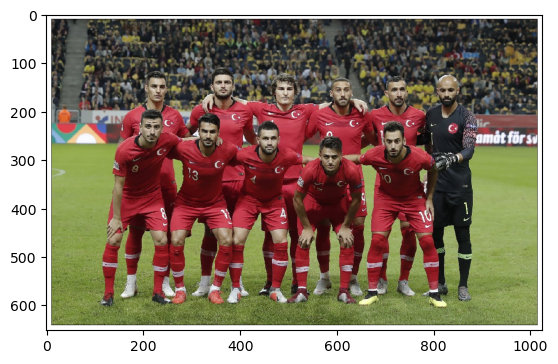

In [20]:
# load in the original image
image = cv2.imread(r"Dataset/sportsteam.png")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

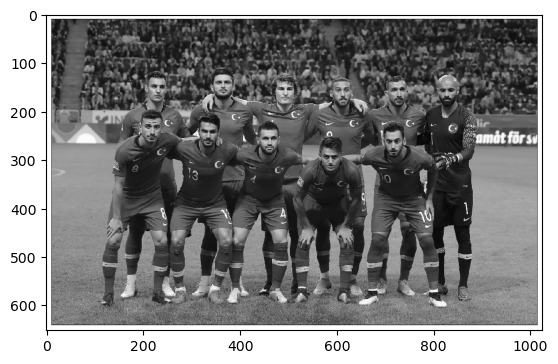

In [21]:
# convert image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

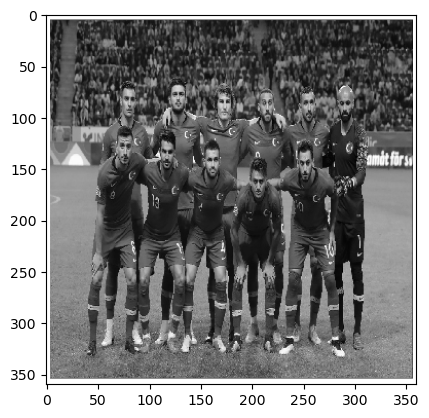

In [22]:
# resize image to a standard format to be used for later 
image_norm = cv2.resize(gray_image, (360, 360))
plt.imshow(image_norm, cmap='gray')



# Neural Network: RetinaFace from RetinaNet
Now, we have demonstrated how we preprocess our image data. First, we ensure it is all grayscale and furthermore, that they are all the same size. We will save these images into a new folder called 'norm_dataset' for neural network creation. We will be using RetinaFace, a neural network built upon the backbone of RetinaNet. The dataset that I will be testing on will be "Face Counting Challenge Analytics Vidhya", a dataset contained 8198 images with labeled faces. Data link is found here: https://www.kaggle.com/datasets/adityendrapba2021/face-counting-challenge-analytics-vidhya

In [9]:
# Preparing our dataset: create normalized image folder
os.makedirs("norm_images", exist_ok = True)

# Path to the folder containing the original images
input_folder = r"Dataset\archive\image_data"

# Iterate over each image file in the input folder
for filename in os.listdir(input_folder):
    # Check if the file is an image (assuming all files are images)
    if filename.endswith(".jpg"):
        # Open the image and read as cv2
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Process the image using the defined function
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_norm = cv2.resize(gray_image, (360, 360))

        # Save the processed image to the "norm_images" directory
        output_path = os.path.join("norm_images", filename[:-4] + "_norm.jpg")
        cv2.imwrite(output_path, image_norm)

print("Processed images saved in directory: norm_images")

Processed images saved in directory: norm_images


This preprocesses all the images on our data. When I ran it, this took approximately a minute, for reference. In our new folder, "norm_images", we now have all our images in the appropriate format. The next step is to run our neural network, RetinaFace, for face detection in these photos and see the results. 

In [10]:
# Import RetinaFace 
# As mentioned in ReadMe, make sure to install beforehand, (e.g. "pip install retina_face" )
from retinaface import RetinaFace

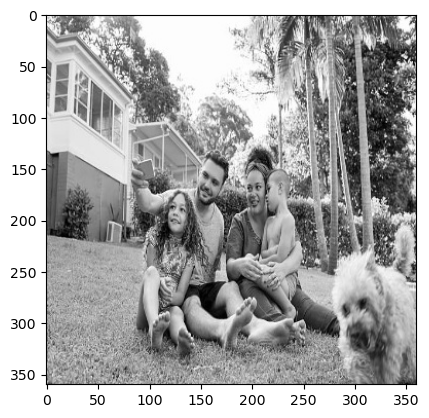

In [12]:
# show a sample normalized image as we use Retinanet to do face detection
image = cv2.imread(r"norm_images\10001_norm.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Number of faces detected:  3


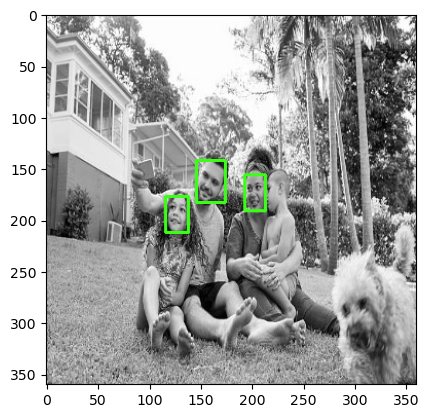

In [35]:
# run the RetinetModel on the sample image 
# Draw rectangles around the detected faces
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

facesBox = RetinaFace.detect_faces(r"norm_images\10001_norm.jpg")
for key, value in facesBox.items():
    # Access the array with the key "facial_area"
    arr = value["facial_area"]
    cv2.rectangle(image, (arr[0], arr[1]), (arr[2], arr[3]), (57, 255, 20), 2)
    
# Display the image with rectangles around faces
print("Number of faces detected: ", len(facesBox))
plt.imshow(image)

So we can see that Retinanet finds three distinct faces. By utilizing the datasets "train.csv" that the images come with, we can find how many faces there actually are. We can compare the results of how Retinanet did at detecting faces against the labeled amount of faces. We will continue by utilizing the above image. 

In [29]:
# read in the dataset detailing headcount
facesnum = r"Dataset\archive\train.csv" 
df = pd.read_csv(facesnum)
image_name = r"10001.jpg"

# Find the row where the "Name" column matches the JPEG file name
matching_row = df[df['Name'] == image_name]

# Print the total amount of faces found vs how many are there
if not matching_row.empty:
    # Get the value in the "Headcount" column
    headcount_value = matching_row['HeadCount'].iloc[0]
    print("Number of faces detected: ", len(facesBox), " out of a total of ", headcount_value, " faces.")


Number of faces detected:  3  out of a total of  4  faces.


So we verified that we did indeed not detect all the faces. Retinanet only detected three, as shown in the neon green boxes on the above image, and missed one. Let's use the next dataset, "bbox_train.csv" to identify where the face that it missed is. 

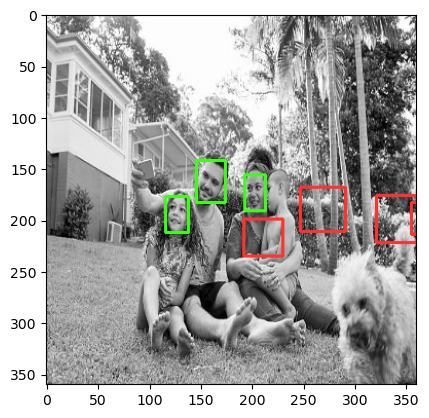

In [39]:
# Load the CSV file into a DataFrame
csv_file = r"Dataset\archive\bbox_train.csv"
df = pd.read_csv(csv_file)

# Filter rows where the "Name" column contains "10001.jpg"
matching_rows = df[df['Name'].str.contains("10001.jpg")]

# Initialize an empty list to store arrays
arrays = []

# Iterate over the matching rows
for index, row in matching_rows.iterrows():
    # Extract values from "xmin", "xmax", "ymin", and "ymax" columns
    xmin = row['xmin']
    xmax = row['xmax']
    ymin = row['ymin']
    ymax = row['ymax']
    
    # Create a 4-element array
    array = [xmin, ymin, xmax, ymax]
    
    # Add the array to the list
    arrays.append(array)

# Convert the list of arrays to a NumPy array
result_array = np.array(arrays)

# Plot the rectangles against what we had 
image = cv2.imread(r"norm_images\10001_norm.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
facesBox = RetinaFace.detect_faces(r"norm_images\10001_norm.jpg")

# create green boxes for faces we detected
for key, value in facesBox.items():
    # Access the array with the key "facial_area"
    arr = value["facial_area"]
    cv2.rectangle(image, (arr[0], arr[1]), (arr[2], arr[3]), (57, 255, 20), 2)

# create red boxes for the labeled data
for entry in result_array:
    cv2.rectangle(image, (entry[0], entry[1]), (entry[2], entry[3]), (255, 49, 49), 2)

plt.imshow(image)

Evidently, this isn't right. That is because the labeled coordinates are for the UNALTERED image. Through a quick tweak, we can apply Retinanet to the unaltered image to get the appropriate boxes.

Number of faces detected:  4  out of a total of  4  faces.


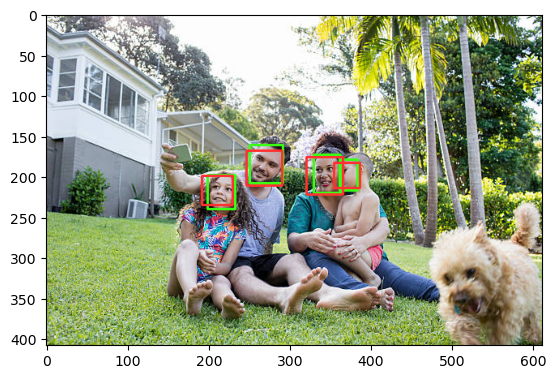

In [43]:

# Plot the rectangles against what we had 
image = cv2.imread(r"Dataset\archive\image_data\10001.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
facesBox = RetinaFace.detect_faces(r"Dataset\archive\image_data\10001.jpg")

# create green boxes for faces we detected
for key, value in facesBox.items():
    # Access the array with the key "facial_area"
    arr = value["facial_area"]
    cv2.rectangle(image, (arr[0], arr[1]), (arr[2], arr[3]), (57, 255, 20), 2)

# create red boxes for the labeled data
for entry in result_array:
    cv2.rectangle(image, (entry[0], entry[1]), (entry[2], entry[3]), (255, 49, 49), 2)

print("Number of faces detected: ", len(result_array), " out of a total of ", headcount_value, " faces.")
plt.imshow(image)

An IMPORTANT matter to note here is that Retinanet actually detected all 4 faces when the image was no longer black and white and made smaller. Whether it was a loss of data when taking away the color or when the face was warped when we made it a certain size, it is imperative to note that the reason is because the data that Retinanet is trained on is unaltered images. Let's continue with two more examples before summarizing the results of the Retinanet model against our large dataset. 

# Example 2:
Result: 4 out of the 4 faces successfully detected with great accuracy shown as the bounding boxes align

Number of faces detected:  4  out of a total of  4  faces.


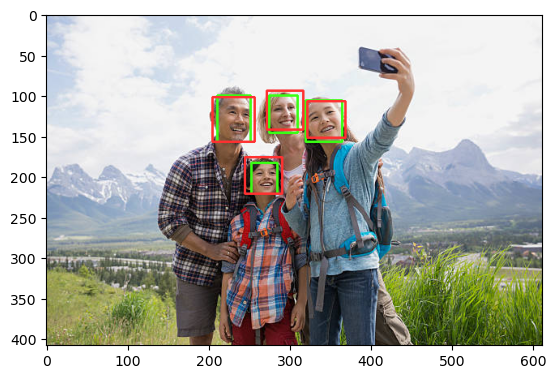

In [51]:
# Filter rows where the "Name" column contains "10420.jpg"
matching_rows = df[df['Name'].str.contains("10420.jpg")]

# Initialize an empty list to store arrays
arrays = []

# Iterate over the matching rows
for index, row in matching_rows.iterrows():
    # Extract values from "xmin", "xmax", "ymin", and "ymax" columns
    xmin = row['xmin']
    xmax = row['xmax']
    ymin = row['ymin']
    ymax = row['ymax']
    
    # Create a 4-element array
    array = [xmin, ymin, xmax, ymax]
    
    # Add the array to the list
    arrays.append(array)

# Convert the list of arrays to a NumPy array
result_array = np.array(arrays)

# Plot the rectangles against what we had 
image = cv2.imread(r"Dataset\archive\image_data\10420.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
facesBox = RetinaFace.detect_faces(r"Dataset\archive\image_data\10420.jpg")

# create green boxes for faces we detected
for key, value in facesBox.items():
    # Access the array with the key "facial_area"
    arr = value["facial_area"]
    cv2.rectangle(image, (arr[0], arr[1]), (arr[2], arr[3]), (57, 255, 20), 2)

# create red boxes for the labeled data
for entry in result_array:
    cv2.rectangle(image, (entry[0], entry[1]), (entry[2], entry[3]), (255, 49, 49), 2)

print("Number of faces detected: ", len(result_array), " out of a total of ", len(facesBox.items()), " faces.")
plt.imshow(image)





# Example 3: 

Result: 0 out of the 5 faces successfully detected with low accuracy

Number of faces detected:  0  out of a total of  5  faces.


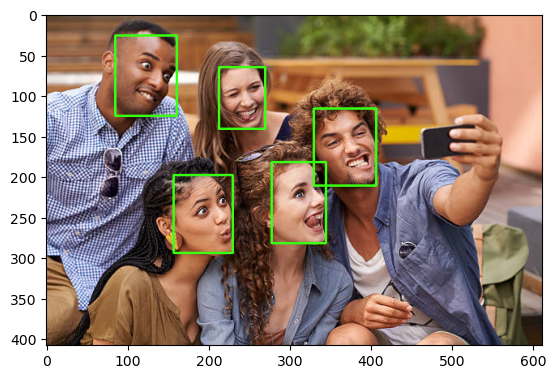

In [53]:

# Filter rows where the "Name" column contains "10029.jpg"
matching_rows = df[df['Name'].str.contains("10029.jpg")]

# Initialize an empty list to store arrays
arrays = []

# Iterate over the matching rows
for index, row in matching_rows.iterrows():
    # Extract values from "xmin", "xmax", "ymin", and "ymax" columns
    xmin = row['xmin']
    xmax = row['xmax']
    ymin = row['ymin']
    ymax = row['ymax']
    
    # Create a 4-element array
    array = [xmin, ymin, xmax, ymax]
    
    # Add the array to the list
    arrays.append(array)

# Convert the list of arrays to a NumPy array
result_array = np.array(arrays)

# Plot the rectangles against what we had 
image = cv2.imread(r"Dataset\archive\image_data\10029.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
facesBox = RetinaFace.detect_faces(r"Dataset\archive\image_data\10029.jpg")

# create green boxes for faces we detected
for key, value in facesBox.items():
    # Access the array with the key "facial_area"
    arr = value["facial_area"]
    cv2.rectangle(image, (arr[0], arr[1]), (arr[2], arr[3]), (57, 255, 20), 2)

# create red boxes for the labeled data
for entry in result_array:
    cv2.rectangle(image, (entry[0], entry[1]), (entry[2], entry[3]), (255, 49, 49), 2)

print("Number of faces detected: ", len(result_array), " out of a total of ", len(facesBox.items()), " faces.")
plt.imshow(image)

It is interesting to note that these NOT NORMAL facial expressions are not recognized by our Retinanet model, Retinaface. This is most likely due to the fact that the faces that the model was trained on DID NOT INCLUDE facial expressions that were not as normal. For example, if you had a mugshot database for training facial detection, you most likely would not have high accuracy for smiling faces when using that model. This follows a similar concept. 

# Summary:

In [60]:
numberOfLabeledFaces = 0
numberOfDetectedFaces = 0
numberOfCorrectNumFaces = 0
numberOfTotalImages = 0

# set the random seed
random.seed(360)

# get the labeled amount of faces
facesnum = r"Dataset\archive\train.csv" 
df = pd.read_csv(facesnum)

# randomly sample 100 image files
files = os.listdir(r"Dataset\archive\image_data")

# Choose 100 random files
random_files = random.sample(files, 100)

# Iterate over each image file in the input folder
for filename in random_files:
    # Check if the file is an image (assuming all files are images)
    if filename.endswith(".jpg"):
        # Check the image path and use Retinaface to detect faces
        image_path = os.path.join(input_folder, filename)
        facesBox = RetinaFace.detect_faces(image_path)

        # Find the row where the "Name" column matches the JPEG file name
        matching_row = df[df['Name'] == filename]

        # Print the total amount of faces found vs how many are there
        if not matching_row.empty:
            # Get the value in the "Headcount" column
            headcount_value = matching_row['HeadCount'].iloc[0]

            # save number of labeled faces in image
            numberOfLabeledFaces += headcount_value

            # save number of detected faces in image using Retinaface
            numberOfDetectedFaces += len(facesBox.items())

            # if they are equal, make sure to mark this as a correct image
            if headcount_value == len(facesBox.items()):
                numberOfCorrectNumFaces += 1
                
    # Store total number of images
    numberOfTotalImages += 1


print("Number of faces detected: ", numberOfDetectedFaces, " out of a total of ", numberOfLabeledFaces, " faces.")
print("Out of ", numberOfTotalImages, " total images, RetinaFace had the correct number of faces detected in ", numberOfCorrectNumFaces, " images.")

# runtime was approximately a minute and a half

Number of faces detected:  285  out of a total of  291  faces.
Out of  100  total images, RetinaFace had the correct number of faces detected in  58  images.


Initially, I had this running for all 8198 images in the dataset, but it was taking too long. I decided to run this instead for two stages: 100 random, then 250 random images from this folder to see the results. 100 images is shown above and 500 is shown below.

In [61]:
numberOfLabeledFaces = 0
numberOfDetectedFaces = 0
numberOfCorrectNumFaces = 0
numberOfTotalImages = 0

# set the random seed
random.seed(360)

# get the labeled amount of faces
facesnum = r"Dataset\archive\train.csv" 
df = pd.read_csv(facesnum)

# randomly sample 100 image files
files = os.listdir(r"Dataset\archive\image_data")

# Choose 100 random files
random_files = random.sample(files, 250)

# Iterate over each image file in the input folder
for filename in random_files:
    # Check if the file is an image (assuming all files are images)
    if filename.endswith(".jpg"):
        # Check the image path and use Retinaface to detect faces
        image_path = os.path.join(input_folder, filename)
        facesBox = RetinaFace.detect_faces(image_path)

        # Find the row where the "Name" column matches the JPEG file name
        matching_row = df[df['Name'] == filename]

        # Print the total amount of faces found vs how many are there
        if not matching_row.empty:
            # Get the value in the "Headcount" column
            headcount_value = matching_row['HeadCount'].iloc[0]

            # save number of labeled faces in image
            numberOfLabeledFaces += headcount_value

            # save number of detected faces in image using Retinaface
            numberOfDetectedFaces += len(facesBox.items())

            # if they are equal, make sure to mark this as a correct image
            if headcount_value == len(facesBox.items()):
                numberOfCorrectNumFaces += 1
                
    # Store total number of images
    numberOfTotalImages += 1


print("Number of faces detected: ", numberOfDetectedFaces, " out of a total of ", numberOfLabeledFaces, " faces.")
print("Out of ", numberOfTotalImages, " total images, RetinaFace had the correct number of faces detected in ", numberOfCorrectNumFaces, " images.")

# runtime was approximately 3 and a half minutes

Number of faces detected:  693  out of a total of  710  faces.
Out of  250  total images, RetinaFace had the correct number of faces detected in  135  images.


In conclusion, Retinaface identified 978 faces out of 1001 faces. However, it only identifed the correct number of faces in 198 out of 350 total images. Running the Retinaface model with the Retinanet backbone showcases how although it can be highly accurate when assigned to tasks that meet specific needs such as face detection, if those parameters by which it was trained on are not seen in new data, these models can still perform quite poorly. We saw that showcased quite well in Example 3. 

# Additional Note:
We've shown that Retinaface is built robust enough to recognize faces without preprocessing the data; using spatial features such as the eyes to align the face. We can see it in action here when we set the parameter: align = True on our sample sportsteam.png. By using where it detects the facial features, it can twist the picture for each region to show the detected face(s) head-on. 

Number of faces detected:  11


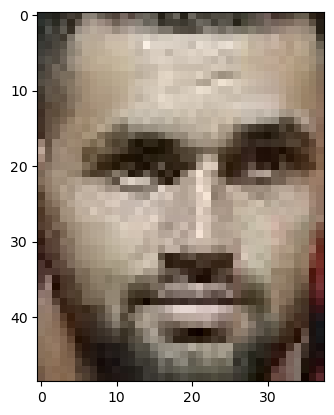

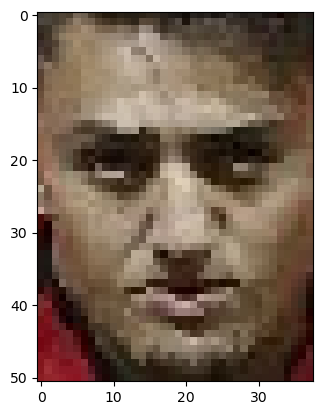

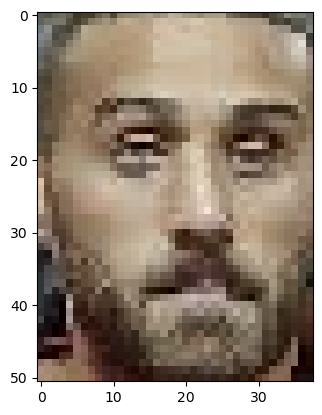

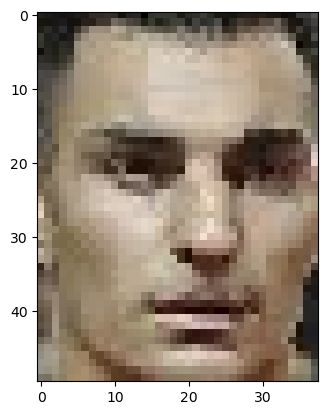

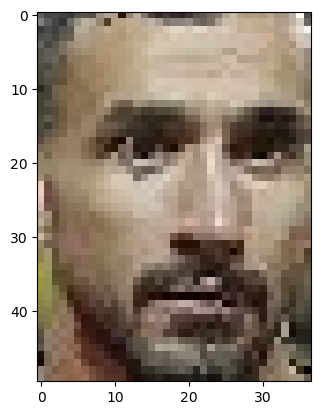

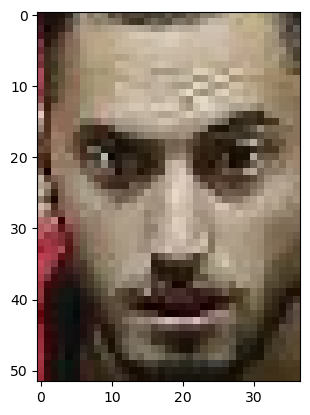

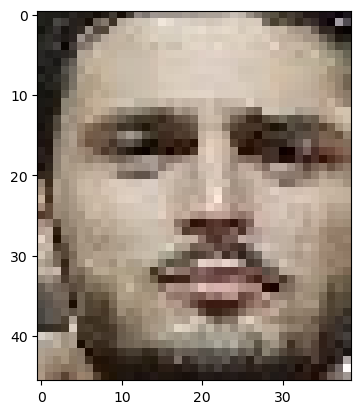

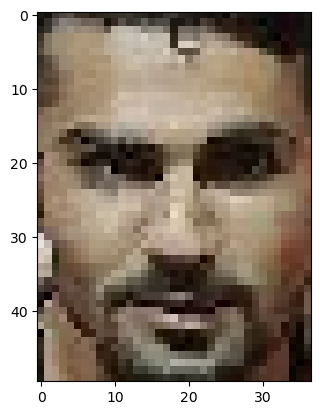

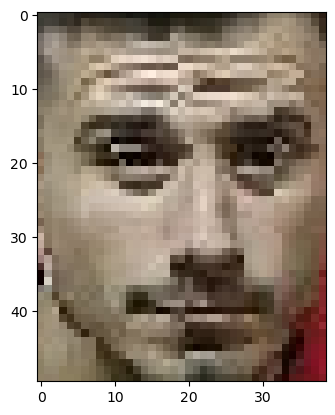

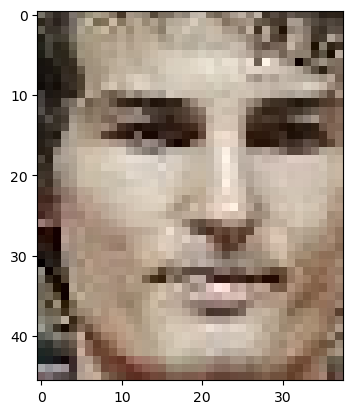

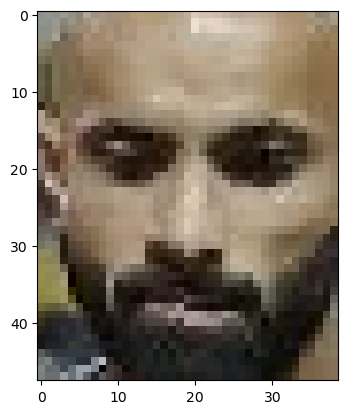

In [23]:
faces = RetinaFace.extract_faces(img_path = r"Dataset\sportsteam.png", align = True)
print("Number of faces detected: ", len(faces))
for face in faces:
  plt.imshow(face)
  plt.show()

Image with detected faces in bounding boxes shown below. 

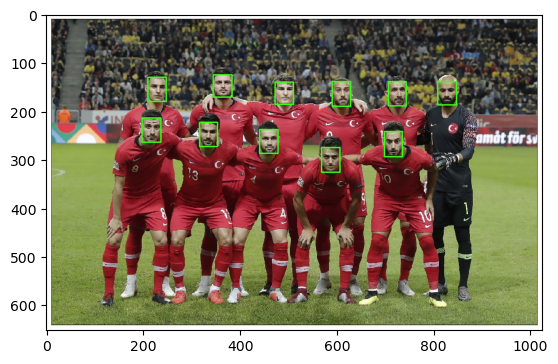

In [20]:
img = cv2.imread(r"Dataset\sportsteam.png")

# Draw rectangles around the detected faces
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

facesBox = RetinaFace.detect_faces(img_path = r"Dataset\sportsteam.png")
for key, value in facesBox.items():
    # Access the array with the key "facial_area"
    arr = value["facial_area"]
    cv2.rectangle(img, (arr[0], arr[1]), (arr[2], arr[3]), (57, 255, 20), 2)
    
# Display the image with rectangles around faces
plt.imshow(img)